In [1]:
from keras_segmentation.models import unet
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import re
import glob
from utils_segmentation import bb_intersection_over_union, build_hist
import numpy as np

Using TensorFlow backend.
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vasylcf/anaconda3/lib/python3.7/site-packages/t

In [2]:
# data = pd.read_csv('data_fortnite.csv')
data = pd.read_csv('data_fortnite.csv')
data.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,95,233,637,213,631,1025,99,1027,1,0GD3EH8SIE_0.jpg,1
1,856,165,1160,163,1157,206,859,213,2,0GD3EH8SIE_1.jpg,2
2,769,474,1146,471,1145,509,771,511,3,0GD3EH8SIE_1.jpg,2
3,1546,353,1779,354,1779,384,1546,387,4,0GD3EH8SIE_1.jpg,2
4,869,143,1145,137,1147,197,863,201,2,0L1EIKM8SU_0.jpg,2


In [3]:
data.labels.unique()

array([1, 2, 3, 4, 5, 6, 8])

In [4]:
data.labels = data.labels.apply(lambda x: 7 if x==8 else x)

In [5]:
n_cl = data.labels.unique().shape[0]

In [6]:
n_cl

7

## Create mask

In [ ]:
for f in data.fname.unique():
    img = cv2.imread('data/img/'+f)
    mask = np.zeros(img.shape)
    F = data[data.fname==f]
    for cl in F['labels']:
        pts = F[data['labels']==cl][['bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4']].values[0].reshape(4,2)
        mask = cv2.fillPoly(mask,[pts],color=(cl,cl,cl))
    cv2.imwrite('data/annotations/'+f.split('.')[0]+'.png',mask)

In [ ]:
f_name = 'data/img/0GD3EH8SIE_0.jpg'
m_name = 'data/annotations/0GD3EH8SIE_0.png'
img = cv2.imread(f_name)
msk = cv2.imread(m_name)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(msk*50)

In [ ]:
files = glob.glob('data/img/*.jpg')
row = len(files)

In [ ]:
i=1
plt.figure(figsize=(16,60))
for f in data.fname.unique():
    img = cv2.imread('data/img/'+f)
    msk = cv2.imread('data/annotations/'+f.split('.')[0]+'.png')
    plt.subplot(row,2,i)
    i+=1
    plt.imshow(img)
    plt.subplot(row,2,i)
    i+=1
    plt.imshow(msk*50)

## Create dataset

In [ ]:
for f in data.fname.unique():
    img = cv2.imread('data/img/'+f)
    seg = cv2.imread('data/annotations/'+f.split('.')[0]+'.png')
    img_r = cv2.resize(img, (224,224))
    seg_r = cv2.resize(seg, (224,224))
    cv2.imwrite('data/images_train/'+f.split('.')[0]+'.png',img_r)
    cv2.imwrite('data/annotations_train/'+f.split('.')[0]+'.png',seg_r)

In [ ]:
img_path = 'data/images_train/'
annot_path = 'data/annotations_train/'
images = glob.glob('data/images_train/*.png')
annotations = glob.glob('data/annotations_train/*.png')
augmentation_images(images,annotations,img_path,annot_path)

##  Validation set

In [ ]:
# ACDD33A017_1.jpg  type_1
# ACDD33A017_0.jpg  type_2
# D5BYODK0RQ_0.jpg  type_3
# KJPCNUM8J0_1.jpg  type_5


!mv data/images_train/ACDD33A017_1*.png data/validation/
!mv data/images_train/ACDD33A017_0*.png data/validation/
!mv data/annotations_train/ACDD33A017_1*.png data/annotation_validation/
!mv data/annotations_train/ACDD33A017_0*.png data/annotation_validation/

!mv data/images_train/D5BYODK0RQ_0*.png data/validation/
!mv data/images_train/KJPCNUM8J0_1*.png data/validation/
!mv data/annotations_train/D5BYODK0RQ_0*.png data/annotation_validation/
!mv data/annotations_train/KJPCNUM8J0_1*.png data/annotation_validation/

## Model

In [7]:
model = unet.mobilenet_unet(n_classes=n_cl+1, input_height=224, input_width=224,)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model.train(
    train_images =  "data/images_train/",
    train_annotations = "data/annotations_train/",
    validate = True,
    val_images = "data/validation/",
    val_annotations = "data/annotation_validation/",
    epochs=5
)

In [ ]:
# model.save('fortnite_8_classes.h5')

In [ ]:
out_1 = model.predict_segmentation(inp="data/images_train/0GD3EH8SIE_0.png")
out_2 = model.predict_segmentation(inp="data/images_train/0GD3EH8SIE_1.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('0GD3EH8SIE_0')
plt.imshow(out_1)
plt.subplot(1,2,2)
plt.title('0GD3EH8SIE_1')
plt.imshow(out_2)

In [ ]:
out_1 = model.predict_segmentation(inp="data/images_train/2O9IZO5MRK_0.png")
out_2 = model.predict_segmentation(inp="data/images_train/8A9B87F189_1.png")
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title('2O9IZO5MRK_0')
plt.imshow(out_1)
plt.subplot(1,2,2)
plt.title('8A9B87F189_1')
plt.imshow(out_2)

## Test of Model

In [ ]:
# file from alexandr
# select images from folder
# calc accuracy

In [8]:
model.load_weights('fortnite_8_classes.h5')

## Test IOU

In [9]:
test_data = pd.read_csv('data_fortnite_test.csv')
test_data.labels = test_data.labels.apply(lambda x: 7 if x==8 else x)
test_data.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type
0,51,181,589,183,585,1061,53,1059,1,3AB6FC95D6_1.jpg,1
1,177,801,1753,777,1753,2893,201,2901,1,4Z8ZB18LX0_0.jpg,1
2,59,127,397,133,394,642,63,643,1,8B9ECC54EF_0.jpg,1
3,55,177,587,187,587,1055,57,1055,1,8TWOSPPEX0_0.jpg,1
4,95,207,637,215,635,1031,103,1031,1,9AD567E63A_0.jpg,1


In [10]:
test_data.img_type.unique()

array([1, 2, 3, 5])

In [11]:
#map img_type and number of classes on image
n_classes_map = {1: 1, 2: 3, 3:2 , 5:2 }

In [12]:
test_data['n_classes'] = test_data.img_type.apply(lambda x: n_classes_map[x])
test_data.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,bbox_x3,bbox_y3,bbox_x4,bbox_y4,labels,fname,img_type,n_classes
0,51,181,589,183,585,1061,53,1059,1,3AB6FC95D6_1.jpg,1,1
1,177,801,1753,777,1753,2893,201,2901,1,4Z8ZB18LX0_0.jpg,1,1
2,59,127,397,133,394,642,63,643,1,8B9ECC54EF_0.jpg,1,1
3,55,177,587,187,587,1055,57,1055,1,8TWOSPPEX0_0.jpg,1,1
4,95,207,637,215,635,1031,103,1031,1,9AD567E63A_0.jpg,1,1


In [13]:
len(test_data.fname.unique())

20

In [ ]:
raw_dir = '/home/vasylcf/Downloads/screenshots_Fortnite/Fortnite/'

In [ ]:
# for f in test_data.fname.unique():
#     img = cv2.imread(raw_dir+f)
#     cv2.imwrite('data/test_imgs/'+f, img)

In [ ]:
# img_folder = 'data/test_imgs/'
# annotation_folder = 'data/test_annotations/'
# create_annotations(test_data,img_folder, annotation_folder)

In [ ]:
test_files = glob.glob('data/test_imgs/*.jpg')
row = len(test_files)
i=1

plt.figure(figsize=(16,60))
for f in test_data.fname.unique():
    img = cv2.imread('data/test_imgs/'+f)
    msk = cv2.imread('data/test_annotations/'+f.split('.')[0]+'.png')
    plt.subplot(row,2,i)
    i+=1
    plt.imshow(img)
    plt.subplot(row,2,i)
    i+=1
    plt.imshow(msk*50)

In [14]:
def detect_classes_v(img,n_classes):
    """
    Detect classes that are most represemted on mask
    """
    labels, counts = np.unique(img,return_counts=True)
    labels = labels[1:]
    counts = counts[1:]
    inds = np.argsort(counts)
    list_classes = []
    
    for i in range(1,n_classes+1):
        list_classes.append(labels[inds[-i]])
        if len(labels)==1:
            break
        
    return list_classes

def find_segments_v(mask_img,cls):
    """
    Find segments on mask
    Inputs:
    mask_img - segmentation mask image from model
    cls - labels of classes that are on image
    Outputs:
    segments - segmnets that were found

    """
    thresh_1 = 0
    segments={}
    for cl in cls:
        cols = np.sum(mask_img==cl,axis=1)
        rows = np.sum(mask_img==cl,axis=0)
        col_cond1= (cols>=np.mean(cols[cols>thresh_1])/1.5)
        row_cond1= (rows>=np.mean(rows[rows>thresh_1])/1.5)
        
        col_indecies = np.where(col_cond1)[0]
        row_indecies = np.where(row_cond1)[0]

        x1 = row_indecies[0]
        y1 = col_indecies[0]
        x2 = row_indecies[-1]
        y2 = col_indecies[-1]
        
        segments[cl] = [(x1,y1),(x2,y2)]
    return segments

def crop_rect_v(im, rect, scaler={'h': 1, 'w': 1}):
    """
    Crop original image by segments.
    Input:
    im - raw image
    rect - rectangle for cropping
    scaler - scaler for rectangle
    Return:
    crop_img - crop segment with original resolution
    coordinates - coordinates of crop rectangle
    """
    k=5
    
    h1 = int(rect[0][1]*scaler['h'])
    w1 = int(rect[0][0]*scaler['w'])
    h2 = int(rect[1][1]*scaler['h'])
    w2 = int(rect[1][0]*scaler['w'])
    crop_img = im[h1-k:h2+k, w1-k:w2+k]
    #[(x1,y1),(x2,y2)]
    coordinates = [(w1-k,h1-k),(w2+k,h2+k)]        
    return crop_img, coordinates

In [15]:
def IOU_list_files_v(test_data,model,img_folder='data/test_imgs/',
                   annotation_folder = 'data/test_annotations/',
                  size=(224,224)):

    """
    For testing accuracy of model. I use metric IOU.
    Input:
    test_data - data frame with columns:  'fname','labels','bbox_x1','bbox_y1','bbox_x2','bbox_y2','bbox_x3','bbox_y3','bbox_x4','bbox_y4'
    img_folder - folder with test images

    """
    m=np.array([[True,True],[False,False],[True,True],[False,False]])
    
    predicted_boxes = {}
    real_boxes = {}
    IOUs = {}

    for f in test_data.fname.unique():
              
        n_classes = test_data[test_data.fname == f].n_classes.values[0]

        img = cv2.imread(img_folder+f)
        img_r = cv2.resize(img, size)

        out = model.predict_segmentation(img_r)
        h_scale = img.shape[0] / out.shape[0]
        w_scale = img.shape[1] / out.shape[1]
        scaler = {'h': h_scale, 'w': w_scale, }
        list_cls = detect_classes_v(out,n_classes)
        rects = find_segments_v(out,list_cls)
        segments = {}
        for r in rects:
            crop_img, coordinates = crop_rect_v(img, rects[r], scaler=scaler)
            segments[r]={'data': crop_img, 'coordinates':coordinates}

        predicted_boxes[f] = segments

        real_boxes[f]={}
        IOUs[f] = {}

        for l in test_data[test_data.fname==f].labels:
            pts=test_data[(test_data.fname==f)&(test_data.labels==l)][['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'bbox_x3', 'bbox_y3',
       'bbox_x4', 'bbox_y4']].values[0].astype('int').reshape(4,2)
            real_boxes[f][l] = pts[m]
            if segments.get(l,0):
                boxA= np.ravel(segments[l]['coordinates'])
                boxB = pts[m]
                IOUs[f][l] = bb_intersection_over_union(boxA, boxB)
            else:
                IOUs[f][l] = 0
            
    return IOUs

In [16]:
IOUs = IOU_list_files_v(test_data,model,img_folder='data/test_imgs/',
                   annotation_folder = 'data/test_annotations/',
                  size=(224,224))
IOUs

{'3AB6FC95D6_1.jpg': {1: 0.9510495390857395},
 '4Z8ZB18LX0_0.jpg': {1: 0.9710223739574587},
 '8B9ECC54EF_0.jpg': {1: 0.9862067377438},
 '8TWOSPPEX0_0.jpg': {1: 0.898800005036705},
 '9AD567E63A_0.jpg': {1: 0.9675595138072033},
 '4BF14869E1_1.jpg': {2: 0.14323407463249152,
  3: 0.1991619959732274,
  4: 0.21532889356233204},
 '4Z8ZB18LX0_1.jpg': {2: 0.19800309441471292,
  3: 0.1167407950845981,
  4: 0.021554776136606894},
 '5GCCFRJIUU_1.jpg': {2: 0, 3: 0.0, 4: 0},
 'E708CACBAC_1.jpg': {2: 0.26592620280877877,
  3: 0.1945181255526083,
  4: 0.316008316008316},
 'N3WKQYXZDE_1.jpg': {2: 0, 3: 0.018251851851851852, 4: 0},
 '1MXQEUNZHU_0.jpg': {5: 0.8653172573377177, 6: 0.041719342604298354},
 '9LZOTWB3GK_0.jpg': {5: 0.9244664868339451, 6: 0.10288713910761155},
 'D1BTKCNDOU_0.jpg': {5: 0.3390743509263535, 6: 0},
 'DK0RQQX9U_0.jpg': {5: 0.9740886488230195, 6: 0.3150414528227398},
 'FCWLBWTXRU_0.jpg': {5: 0.9079435321069098, 6: 0},
 '7KTZALA0_0.jpg': {7: 0.604585646146551, 4: 0},
 '20E92A2CC0_0.j

In [17]:
ACC = pd.DataFrame.from_dict(IOUs, orient='index')
ACC.mean()

1    0.954928
2    0.121433
3    0.105735
4    0.199213
5    0.802178
6    0.091930
7    0.646917
dtype: float64

In [184]:
# Visualize results for each image

In [27]:
def analysis_v(f, model, path='data/test_imgs/', size=(224,224), test_data=test_data):
    """
    Visualization of work of model
    """
    n_classes = test_data[test_data.fname == f].n_classes.values[0]
    img = cv2.imread(path+f)
    img_r = cv2.resize(img, size)
    img_r_mask = cv2.resize(img, (int(size[0]/2),int(size[1]/2)))

    out = model.predict_segmentation(img_r)

    # h_scale = int(np.round(img.shape[0] / out.shape[0], 0))
    # w_scale = int(np.round(img.shape[1] / out.shape[1], 0))
    h_scale = img.shape[0] / out.shape[0]
    w_scale = img.shape[1] / out.shape[1]
    scaler = {'h': h_scale, 'w': w_scale, }

    list_cls = detect_classes_v(out,n_classes)
    rects = find_segments_v(out,list_cls)
    segments = []
    for r in rects:
        crop_img, coordinates = crop_rect_v(img, rects[r], scaler=scaler)
        segments.append({'label': r, 'data': crop_img, 'coordinates':coordinates})
        
        cv2.rectangle(img_r_mask,*rects[r],(255,255,0),2)

    print(f'Find segments: {len(segments)}')
    plt.figure(figsize=(16,16))
    plt.subplot(2,3,1)
    plt.title(f"Label: {segments[0]['label']}")
    plt.imshow(segments[0]['data'])
    plt.subplot(2,3,2)
    if  len(segments)>1:
        plt.title(f"Label: {segments[1]['label']}")
        if segments[1]['data'].any():
            plt.imshow(segments[1]['data'])
    else:
        plt.title(f"Label: None")
    plt.subplot(2,3,3)
    if  len(segments)>2:
        plt.title(f"Label: {segments[2]['label']}")
        plt.imshow(segments[2]['data'])
    else:
        plt.title(f"Label: None")
    plt.subplot(2,3,4)
    plt.title(f"mask")
    plt.imshow(out)
    plt.subplot(2,3,5)
    plt.title(f"image")
    plt.imshow(img_r_mask)
    return out

In [28]:
#test_data

Find segments: 1


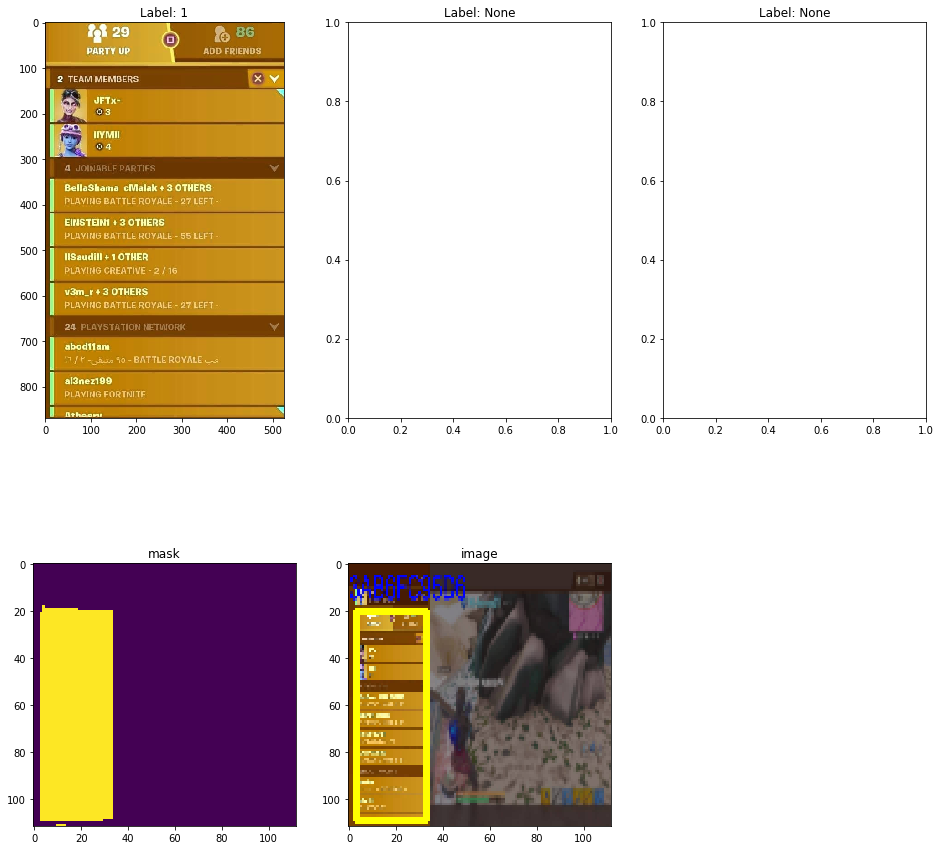

In [34]:
fname='3AB6FC95D6_1.jpg'
msk = analysis_v(f=fname, model=model)

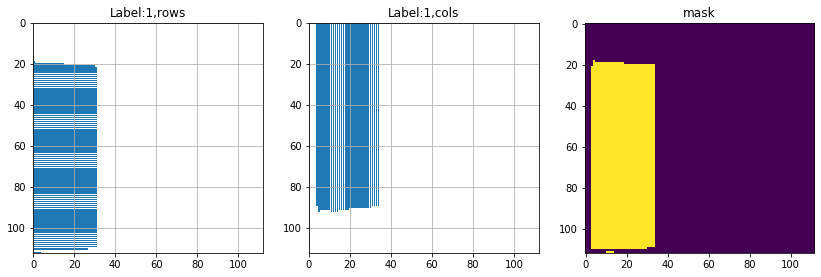

In [35]:
build_hist(msk,[1])

Find segments: 3


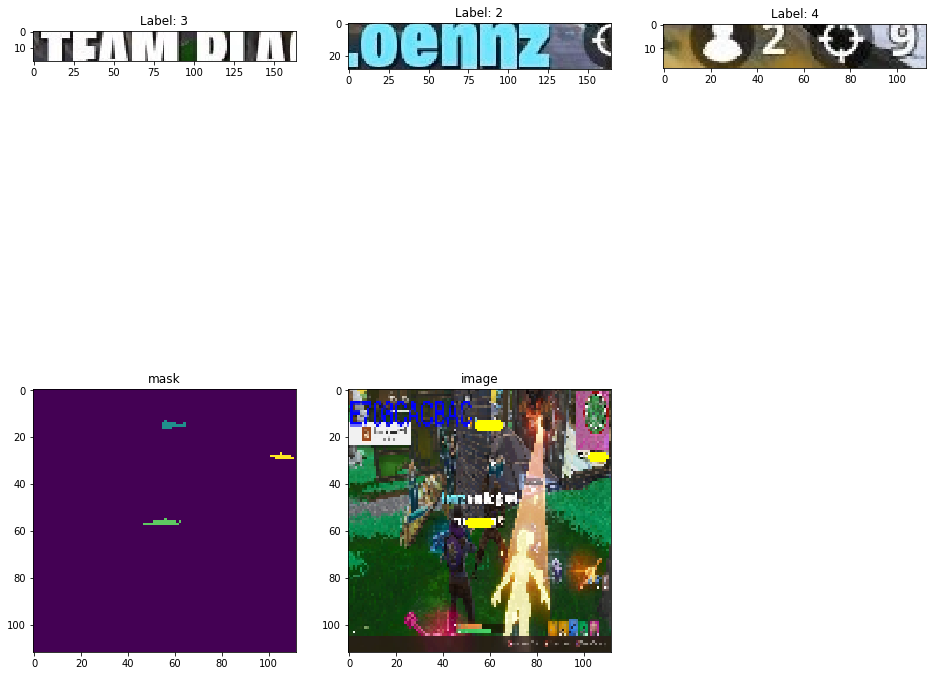

In [36]:
fname='E708CACBAC_1.jpg'
msk = analysis_v(f=fname, model=model)

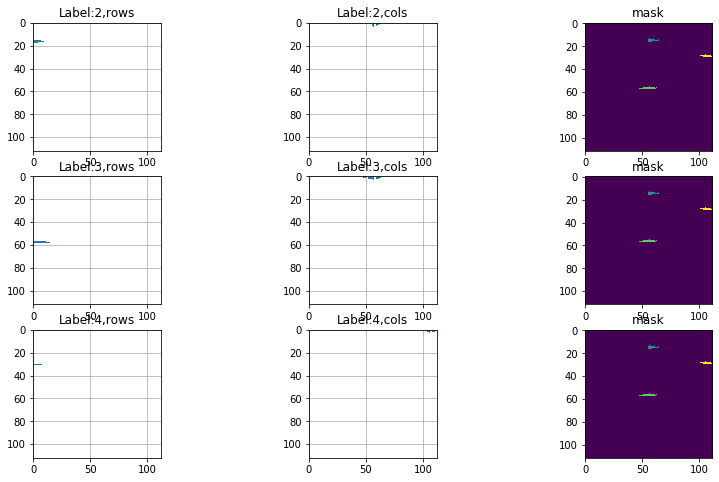

In [38]:
build_hist(msk,[2,3,4])

Find segments: 2


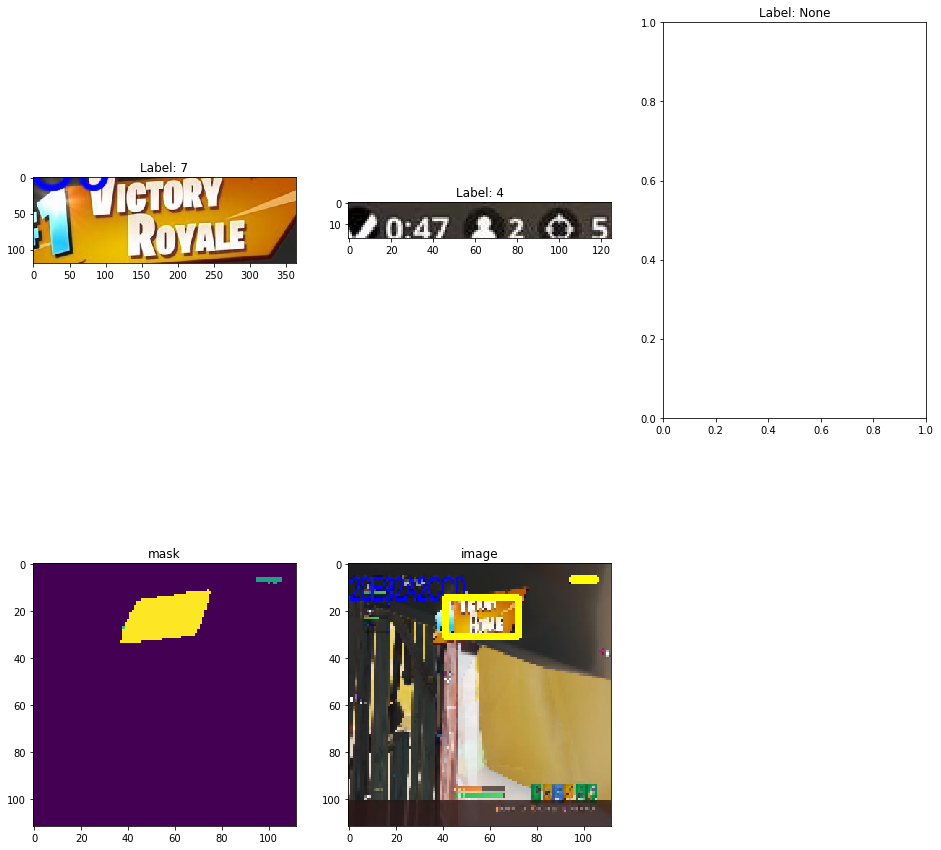

In [31]:
fname='20E92A2CC0_0.jpg'
msk = analysis_v(f=fname, model=model)

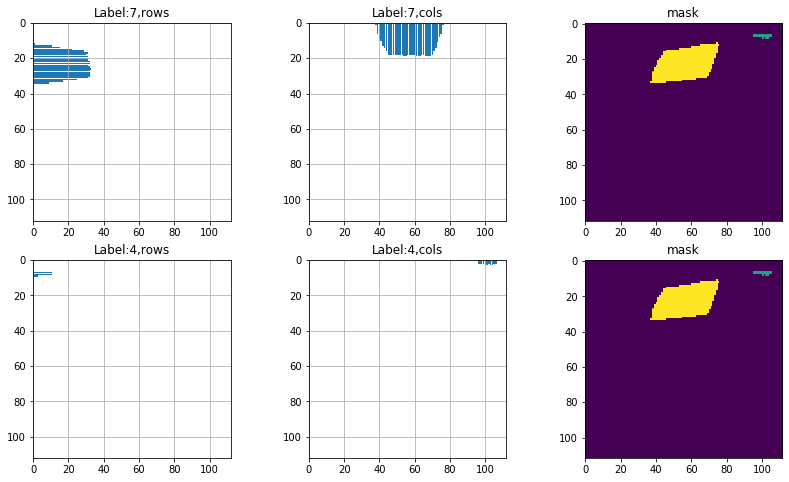

In [32]:
build_hist(msk,[7,4])

Find segments: 2


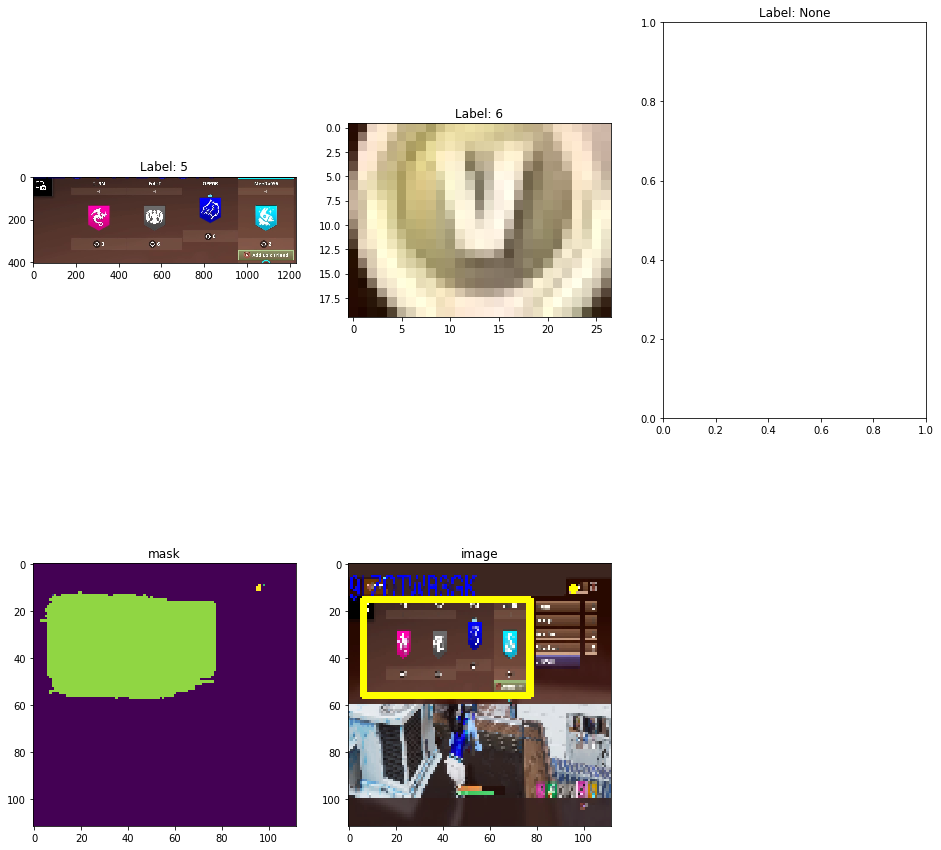

In [40]:
fname='9LZOTWB3GK_0.jpg'
msk = analysis_v(f=fname, model=model)

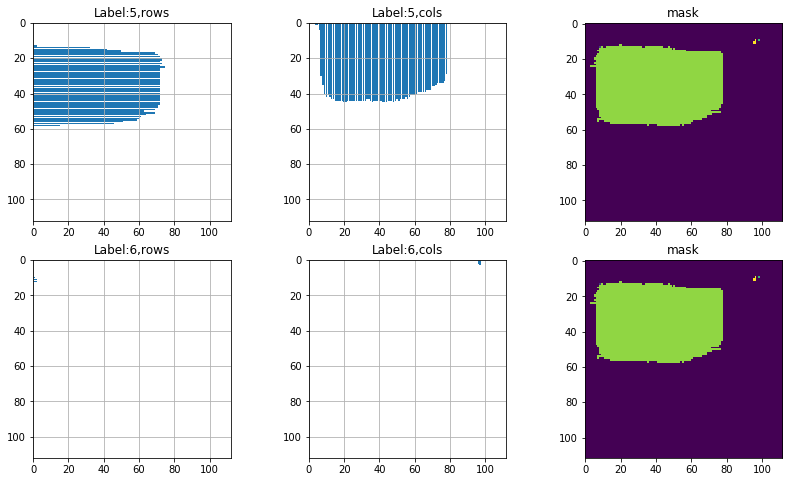

In [41]:
build_hist(msk,[5,6])

In [ ]:
# reduce classes
# reject from label 2, 6
# make bigger label 4
# change algorithm for detection ?

# for small rectangle, you can find center and build own rectangle

## Check hypothesis

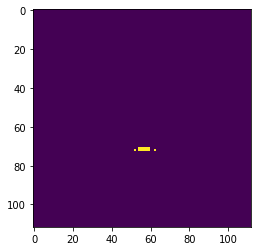

In [47]:
# image type_2 (2,3,4 labels)
path = 'data/test_imgs/'
f='5GCCFRJIUU_1.jpg'
size=(224,224)

img = cv2.imread(path+f)
img_r = cv2.resize(img, size)
img_r_mask = cv2.resize(img, (int(size[0]/2),int(size[1]/2)))
out = model.predict_segmentation(img_r)

plt.imshow(out)

In [48]:
np.unique(out, return_counts=True)

(array([0, 3]), array([12530,    14]))